In one of the X-factor shows, the judges interrupted a candidate who was singing extremely well, suspecting that she was lip syncing to a recording. The interesting video is here - https://www.youtube.com/watch?v=hmvB0Tdmx18. Her natural voice sounded so auto-tuned that I tried to explore the same to see if the freq harmonics 'looked' as neat and well defined as they 'sounded'. 

In any case, I was looking for an excuse to dig a bit more into Sound Feature engineering. Though my previous kernel (https://www.kaggle.com/allohvk/chirrrrrp-welcome-to-my-world) gave a short intro, there were lots of questions unanswered... for e.g. when I define a n_fft=2048 to bin the frequencies(y-axis) why does this value(2048) slide along the x-axis (related to time) in hops...why not a different value or why do we have to compromise between freq and time - why not have highest frequency bins as well as highest timebins? Morevover while there are nice libraries like Librosa providing everything in 1 line of code, I wanted to explore a bit more on what is happening behind the scenes and understand the shapes and values (not just the plots). Hence I decided to use the very basic tensorflow signal function to build everything ground up in an effort to understand things a bit more. Compared to Librosa, documentation is a little sparse for this and I hope this effort helps those seeking to walk a similar path

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import IPython.display as display
import seaborn as sns
from IPython.display import Audio

Let us plot a simple wave first. 

y=np.sin(x)

Intuitively we can say that 'y' has something to do with amplitude and 'x' has something to do with time. Yes, at any time 'x' the value of the wave y = sin (x). 

Let us plot the wave for values of x from 0 to (2 times PI). For now dont worry about this PI business

In [ ]:
x=np.arange(0,2*np.pi,0.1)
y=np.sin(x)

plt.plot(x,y)
plt.show()

Simple enough? Well it depends...

For starters the x-axis is not really the time. Instead it is a function of the angle which goes from 0 to 2𝜋 in one cycle. There is a slight confusion because maybe we see wave as a physical entity and tend to look at x-axis in terms of time or distance, wheras the plot is seeing the wave as a pure mathematical function. Let us see if we can try to reconcile the 2 views.

If we plot 'y' vs 'x', starting from the origin, a wave moves up and then down and then back to 0 after a certain time and repeats this general pattern again and again. This much is clear irrespective of which view you look at it. At the point(when it hits 0), it has moved the distance 𝑥=𝜆 from the origin (its wavelength) and the 'phase' of the wave becomes 𝜙=2𝜋. So we can look at the x-axis as being representative of the 'phase' of the wave. At every multiple of 2𝜋, the wave comes back to 0. It has also moved 340/frequency metres if you want to look at it in terms of distance. This is because sound travels at 340 m/s. The frequency indicates how many waves are produced per second. So assuming we produce a 50Hz sound, this means we are producing 50 waves in one second and the distance travelled = 340 * (1/50) or around 6.8 metres. What is the time for 1 wave? Well if you want to look at x-axis in terms of time, then for a 50 Hz sound, the x-axis will move from 0 to 1/50 (or .02 seconds) for 1 full wave. 

So to summarize:
- y-axis is sort of simple to visualize. It is the energy of the wave at a given 'x'
- x-axis is a bit hard to visualize. What is irrefutable (whichever way you look at it) is that based on the the value of 'x', the value of 'y' starts from 0 and goes up and then comes down and then back to '0'. 

So:
- We can look at x-axis as a function of 'phase' of the wave. The value of 'y' hits 0 every time x traverses by 2𝜋
- We can look at it in terms of distance. The value hits 0 every 340/frequency metres
- In terms of time, the value hits 0 every 1/frequency seconds

Possibly the best way to reconcile the 2 views is to treat x-axis as a function of 'phase' (at least to start out with). So plotting a graph where x from (0) to (2 times PI) gives us one full wave as in the above figure.

Now we come to the last aspect of the x-axis that needs to be understood. In our prev figure, we varied the x-values from 0 to (2 times PI) in increments of 0.1. PI is 3.142, so our x values were 0,0,1, 0,2, 0,3 and so on till 6.2. For each of these 'x' values, 'y' was plotted and we get the graph. Try changing the incremental value of 'x' from 0.1 to 0.01 or 1. If you change it to 0.01, there is no difference - y is calculated for every .01 increment and it still follows that wavy pattern. But try changing the increment to 1 and you immediately see a problem. The wave 'looks' like a wave but you can tell it is distorted. Every time you calculte 'y' from 'x' you are taking a sample. The incremental value of 'x' decides how many samples we take over time and this is called the sampling rate. If you take more samples (every second), you have a faster sampling rate and vice versa. So here is an 'indirect' way in which time forces its presence on the x-axis, even though we chose to discard it in favour of using 'phase' for the x-axis. Since we cannot measure 'phase' on a continual basis, we have to 'sample' it at short intervals of time and this is our sampling rate 'sr'...the number of times we sample/calculate the value of 'y' for a given 'x' over a period of 1 second. 

Thus once we bring in the concept of sampling into the picture, we can say that x is a measure of time - every sample that we take can be plotted on x and the corresponding strength or energy of the signal is plotted on y.

Lastly let us define amplitude bit more formally. It is the height from the center line to the peak. In the above graph we can see that the amplitude is 1. Let us create a wave with amplitude 2. We will also extend the x-axis a bit to (6 times PI)..So we should get 3 full cycles of the wave.

In [ ]:
amp = 2
x=np.arange(0,6*np.pi,0.1)
y=amp*np.sin(x)
plt.plot(x,y)
plt.show()

We will 'shift' the wave slightly on the horizontal axis. Why is this important? This is because in most situations, we can create lots of augmented data by shifting the sound. This is called phase shift. Let us shift by 0.5 and see what happens.

The function needs to be changed slightly as below.

In [ ]:
amp = 2
shift = 0.5
x=np.arange(0,6*np.pi,0.1)
y=amp*np.sin(x+shift)
plt.plot(x,y)
plt.show()

You can see that the wave is not starting at 0 now. It has shifted left. To shift right we can add a -ve value. 

We also can have much faster waves. Let us crank it up a notch shall we? Let us go for 100 times faster waves. 

In [ ]:
speed = 100
amp = 3
x=np.arange(0,6*np.pi,0.1)
y=amp*np.sin(speed*x)

plt.plot(x,y)
plt.show()

Great! Now let us adjust x-axis a bit so we can see the wave clearer

In [ ]:
speed = 100
amp = 3
xaxis_unit = 0.1/speed

x=np.arange(0,(6*np.pi/speed),xaxis_unit)
y=amp*np.sin(speed*x)

plt.plot(x,y)
plt.show()

Lastly, every sound wave anybody produces is almost always addition of waves of different frequencies and amplitude. Let us see one such addition. Let us say when you are singing you produce two sounds - one of frequency 5K and another of frequency 10K. The final (high pitched) sound that comes out is an addition of these two waves.

In [ ]:
frequency1 = 5000
frequency2 = 10000
amp1 = 2
amp2 = 5

xaxis_unit = 0.1/frequency1

x=np.arange(0,(6*np.pi/frequency1),xaxis_unit)
y1=amp1*np.sin(frequency1*x)
plt.plot(x,y1)

x=np.arange(0,(6*np.pi/frequency2),xaxis_unit)
y2=amp2*np.sin(frequency2*x)
plt.plot(x,y2)
plt.show()

Note that for the orange (higher frequency wave), we need to stretch the range before we add the waves. So: 

x=np.arange(0,(***12*** times np.pi/frequency2),xaxis_unit)

Also note that we are not changing xaxis_unit else we cant add these 2 waves.

Now let us see what happens when we add the waves. It is a simple addition

In [ ]:
frequency1 = 5000
frequency2 = 10000
amp1 = 2
amp2 = 5

xaxis_unit = 0.1/frequency1

x=np.arange(0,(6*np.pi/frequency1),xaxis_unit)
y1=amp1*np.sin(frequency1*x)
plt.plot(x,y1)

x=np.arange(0,(12*np.pi/frequency2),xaxis_unit)
y2=amp2*np.sin(frequency2*x)
plt.plot(x,y2)
plt.show()

y=y1+y2
plt.plot(x,y)
plt.show()

This is how all sound is created. So every sound is just a bunch of waves. You can literally split open a sound into its component waves and this is done by a simple Fourier transform (FT). If we do a Fourier transform, then at any point in time we can break the signal into the respective frequencies. We will come to that later.

Now let us come back to this sampling business. We discussed in our previous kernel that if I wanted to capture you singing for 1 sec (no more please) then I need to sample your voice 5000 times in one second and store it in a numpy array. You ask me to increase the sampling rate as you feel the sampling rate would not do justice to your voice and ask me to increase it to the max. I mention that even when Madonna is singing the producers are not going to exceed 40000 samples per second and somehow you are convinced to go for 16K samples. 

So let us go ahead with Sampling Rate sr = 16K and try to capture your sound wave and store it in a numpy array. Let us say, this time you decide to sing in a more 'base' voice and manage to produce a sound for 1 second which is a combination of 2 waves - one at freq 200 Hz with amp=2 and one at 2000 Hz with amp = 5. If we use a sr of 16K, then we must take 16K samples every second. So over 1 second on the x-axis we should have 16K values of y. 

In [ ]:
frequency1 = 200
frequency2 = 2000
amp1 = 2
amp2 = 5
sr = 16000

##x-axis is 't' which varies from 0 to 1 sec with increments of 1/sr
t = np.arange(sr) / float(sr) 
y1 = amp1*np.sin(2*np.pi*t*frequency1)
y2 = amp2*np.sin(2*np.pi*t*frequency2)

signal=y1+y2
plt.plot(t,signal)
plt.show()

Obviously the wave is too dense to be shown above. x varies from 0 to 1 second and in that time period, there are 1000's of waves produced and hence too dense to be shown above unless we clip the x-axis to maybe 1 milli second or something. 

Anyway, you are happy your sound is now immortalized in this numpy array

In [ ]:
print('Shape of you (your sound that is):', signal.shape)
print('\n The sound of music:\n',signal)

and let us listen to this beautiful sound, shall we

In [ ]:
from IPython.display import Audio
Audio(data = signal, rate = sr)

Beautiful, Isnt it

BTW you can generate sounds from 20-20K HZ and test your hearing. I noticed that I have a pretty limited range from 50-15K Hz only :(

Now let us see take a small deviation to see what happens if I have a very low sampling rate. To see it easily on graph, let us assume the frequency you are producing is 5 Hz and sr is only 25

In [ ]:
sr = 25
frequency = 5
amp = 2
duration = 2

t = np.arange(sr) / float(sr) 
y = amp*np.sin(2 * np.pi * frequency * t)

plt.plot(t, y)
plt.show()

Play around with the SR values. If you increase it the graph gets better and better. At around sr = 75, we start getting good representations of the wave sample. Go lesser than sr = 25 and you see even the amplitude starts to deteriorate even for a 5 Hz signal (i.e because you are sampling only few times for each wave and you may not be able to capture the wave at its peak). In general sr should be at least twice your max frequency (though as can be seen for above extreme example, this need not always be enough). However 5Hz is not a sound that the human can hear. In general, considering the range of sounds that the human ear can hear, a sr of 48K is extremely good.

Lastly you can just take a look at the below sampling values:

In [ ]:
for a, b in zip(t, y):
    print ('Sampled at:', a, '    Value:', np.round(b,1))

Let us now move on to what happens on the frequency side of things.

We discussed about Fourier transforms (FT) earlier and how it can split a signal into its constituent frequencies. FT expresses a function as a sum of periodic components. Given a wave vector 'y' of n input amplitudes y[0],y[1]...y[N], the output is a set of frequency magnitudes. What is FFT (Fast Fourier Transforms) then? Well, if FT is a function, FFT can be thought of a particularly fast way to implement that function. So FFT is the implementation module or algorithm which does an efficient FT.

So if we do a Fourier transform on the 'signal' of you singing that we captured above (the one where you sang at 200 Hz and 2000 Hz and I sampled at 16000 times per sec), it should decompose into two frequencies 200 and 2000. Let us try that. We will use tensfor flow's signal FFT conversions

In [ ]:
import tensorflow as tf
freq = tf.signal.fft(signal)
print(freq.shape)


Ideally we would have expected the FFT to give us the 2 freq components, but its shape appears to be 16000 ie the input signal shape. The reason is that Fourier transform does not just give the frequencies present but also gives the magnitude of each frequency present (using the same distribution as time was earlier..hence the 16K frequency magnitudes...all expect 2 of them being 0). 

In fact, to be more precise, it returns the complex-valued amplitudes of the frequencies found in the signal. The first half of this list returns positive-frequency-terms, and the other half returns negative-frequency-terms which are exactly same as the positive ones and hence we need not bother about that. All the relevant info is contained in the first half itself. We need not go into the mathematical details of this 'complex' number and 'real' and 'imaginary' signals

Let us just use the abs() function to get the magnitudes from the first half of the output. We will round it to nearest int.

In [ ]:
freq = np.round(np.abs(freq[:len(freq)//2]))
freq

Much better. Let us try to print the non-zero values

In [ ]:
print('Positions:', np.nonzero(freq))
nonzerofreq = freq[np.array(freq)>0]
print('\nValues:', [int(x) for x in nonzerofreq])

Out of 16K values stored in freq, we can see that there are 2 big ones and these must correspond to your 2 frequencies that you sang(200 Hz and 2000 Hz). The 16003 must correspond to the freq with the lower amplitude (remember we had given amp of 2 to the 200 Hz and amp of 5 to the 2000 one). There is some other small noise among a dozen or so other values and that indicates that FFT does not give a perfect value. For rest of the 159xx values, the frequency magnitude is a perfect 0. 

Now, let us try to plot this and it will be even more clearer 

In [ ]:
def fft_plot():
    samples = len(signal)
    
    ##We saw that x can range from 0 to sr/2 only
    ##It increments by (2/samples) for every unit
    ##from 0 to 2/1600 to 4/16000 to 8/16000 till 8000/16000
    ##a total of 8000 samples on x-axis
    x = np.linspace(0,sr/2,int(samples/2))
    
    ##scale y down before plotting as FFT does some kind of transpose
    plt.plot(x, 2/samples * freq)

fft_plot()

Yes! We can now clearly see the constituent frequencies of the 1 second sound you have produced. Note that if by chance you had decided to sing in a high pitch and managed to produce a 3rd frequency of 10K Hz in that 1 second, our FFT will not be able to capture it. Do you know why?

This is because we discussed in the last kernel that at least 2 samples per wave are needed to capture a sound decently. If you sing at 10KHz, then my sampling rate has to be at least 20KHz to capture your high pitched sound. Since our sr is 16K so the FFT does not even attempt to capture any sound beyond 8K. This is the reason the x-axis is from 0-8K only.

(In fact I had a tough time debugging this when I gave original frequencies as 5K and 10K and sampled at 16K. The FFT produced freq outputs for 5K and 6K and I had a tough time debugging this)

That is pretty much to it. We can play around with this now. If you feel your voice was too high pitched, we could remove the energies from the signal for the freq = 2000 Hz and leave only the 200 Hz. After this we could convert back this frequency represetation to sound representation by doing an inverse FT and lo and behold - you can hear yourself singing in a very base voice only @ 200 Hz

Let us move onto stft and spectograms now.

If you see the above graph, it is like a snapshot in time. By itself that may not tell much about your singing. Just like how we have to listen to the song for at least a couple of seconds to guess who the singer is, similarly it makes sense to generate this FFT over and over again a few times and then combine the images to get an idea of the frequency distribution changing over time so that we can judge what is happening. This is nothing but a spectogram.

A spectrogram thus shows how the frequency content of a signal changes over time. The operation to do that is known as the Short Time Fourier Transform (STFT). We just compute Fourier transforms (FT) over short overlapping windows and then combine these 'frames' to create a spectogram. Note that I used the term 'overlapping windows' because we could lose bits informaiton if there is no overlap. The purpose of overlapping is to reduce the effect of windowing which are taper shaped functions (they drop to 0 as they move from center to frame edges). Here is where hopping comes in which leads to overlap. We average FFT results from overlapping frames and thus obtain a better frequency representation.

So: 
- Break the audio signal into smaller frames(windows) and calculate FFT for each window
- Slide this window all along the signal (with some overlapping).
- Get the FFF values (coefficients)

So now we have the frequencies for each window and window number will be representative of time. 

In terms of numbers, the output is a 2D tensor that you can run standard convolutions on. If we plot it, it becomes a spectogram — one axis represents the time, the second axis represents frequencies and the colors represent magnitude (amplitude) of the observed frequency at a particular time. The overlap can vary from 25% to 75%. In Librosa, it is 75% by default.

Note that we do not measure all frequencies from 0 to infinity. The sfft function does a wise thing. Just likle the FFT, it does not even bother to measure frequency over sr/2 as it knows that it is a waste of time doing so. Thus the freq range it measures is from 0 to sr/2. Also it does not measure them continuously but 'bin's them. We define a parameter (usually n-fft but the variable name may vary depending on the tool you choose) which specifies how many bins we want. 

Let us define the semantics now else this will be a source of confusion later:
- frame_length or window_size or frame_size or win_length: The window size over which we will take the FFT. We can treat frames and windows as being equal for most practical purposes
- frame_step or hop_size or hop_length - tells how many samples we can jump forward after one frame of FFT analysis before calculating the next
- n_fft: The number of frequency bins you want. This is usually (but need not be) the same as frame_length or window_size or frame_size or win_length. If different, then window is padded with zeros to match n_fft. To keep things simple let us henceforth use n_fft = same as window size. In effect, this means we just need to specify 2 parameters: n_fft (or frame_length) and hop_size (also called frame_step) to generate a spectogram. If you want to keep it more simple then you may note that by default hop_length = n_fft/4. So you can only think of n_fft to keep it very simple. But let us for now consider both n_fft and hop_size.

The above semantics confused me a lot initially. Please do go thru' the same again as this could be a source of confusion to newbies

So if n_fft (and therefore frame_length) is 2048 and hop_size is 512, so our first fft is from 0-2048 (remember we decided to keep window length and n_fft as same). The next fft is not from 2048 to 4096 but from 512 (so it spans from 512 to 2048+512). The next one is from 1024 (and it spans from 1024 to 2048+1024). If you look at it this way, then there is 75% overlapping between FFts.

Can we guess the shape of the stft output before actually printing it?

In [ ]:
print(signal.shape)
freq = tf.abs(tf.signal.stft(signal, frame_length=2048, frame_step=512))
print(freq.shape)

Hmmm. This is not what we had in mind I guess. Let us ignore this value and guess what the ideal answer should be.

The x-axis which stands for the number of time-bins should be straightforward. It should be the length of the signal (16000 in our case..remember your audio is 1 second of your singing at sr of 16000) divided by the frame_step.

So dimension 1 = num of time bins = num samples/frame_step = 16000/512 = 32!!!

So our dimension 1 is wrong. Ok no proble, let us check dimension 2.

The second dimension represents frequency bins. We specified the num of freq bins as 2048. However we know all that complex number magic number imaginary number peculiar business which we saw before so let us ignore half of the frequencies due to symmetry. So the number of frequency bins should be 1024!!

So even dimension 2 is wrong. The shape we wanted was (32,1024) and we got (28, 1025)

Never mind. We can quickly fix the second dimension issue. The extra bin stands for 0. So the number of frequency bins is actually 1024+1 = 1025. What is the actual frequency contained in these bins? Well as we discussed earlier the sftt will not even bother to store frequencies greater than sr/2. So the actual ranges in these bins will vary from 0 to sr/2. In our case the range of frequency from 0 to 8000 Hz is divided into 1025 frequency bins and the value in each bin contains the energy of that frequency bin in the sound signal

Let us now look at the first dimension. Why is it 28 and not 32? It took me a while to get there. What tf.signal does is that it calculates the number of time bins to be (16000-2048)/512 ie 28 bins. We were expecting 16000/512 = 32 bins. Well this is just the way tf works and we have to live with it. However we do have an option of padding "pad_end=True" which gives what we want. Basically the last chunk of 2048 samples is padded with (2048-512) zeroes so that there are 4 additional hops over it (remember every hop is 512 samples). Let us try it

In [ ]:
n_fft = 2048  ##Not needed. but just so you remember our framelength = n_fft
sr = 16000  ##yes we know...but we played around with it and set it to 25 earlier
frame_step=512 
frame_length = 2048

freq = tf.abs(tf.signal.stft(signal, frame_length=frame_length, frame_step=frame_step, pad_end=True))
freq.shape

Yay! We got what we want, but not without a bit of headache in the first place. There is no clear documentation available for such behaviour. You can try Librosa and it gives you 32 timebins for same data without explicitly specifying any padding options. Anyway let us move on.

We understood the output shape. Let us try to understand the output values now.

Our hop size is 512. What this effectively means is that for every 512 samples in our audio, a new FFT is calculated and this repeats till the end of all samples is reached. We discussed how there are 32 frames in our 1 second audio. Each frame is 1/32 seconds duration in time.

Each frame contains values for multiple frequency bins. The first bin in the FFT is 0 Hz, the second bin is sr/n_fft. The next bin is 2 * sr/n_fft, the third bin is 3 * sr/n_fft and so on up till sr/2. In our cases the range is from 0 to 1025 in increments of 16000/2048 or around 7.8 Hz

Since your singing contains 2 frequencies at 200 and 2000 Hz, so roughly we should see non-zero values in the bins where these 2 frequencies are housed somewhere around the 25th bin and 250th bin. This should be true for all 32 frames. Let us see if that is true.

In [ ]:
##Take just 1 frame: freq[:1]
##Let us print all non-zero values in this frame
positions = np.nonzero(np.round(freq[:1]))[1]
print('Positions:',positions)
print('\nValues:', [int(freq[:1].numpy()[0,x]) for x in positions])

We indeed see that there are spikes around the 25th and the 256th bin which roughly matches with the crude calculations we have done. Let us now plot this spectogram

In [ ]:
def plot_spectrogram(spectrogram):
    X = np.arange(sr/frame_step)+1
    Y = range(spectrogram.T.shape[0])
    plt.figure(figsize=(12,10))
    plt.pcolormesh(X, Y, spectrogram.T)

plot_spectrogram(freq.numpy())

Neat! You can see the two frequencies you sang in. Let us quickly check on the 3 axis shapes

In [ ]:
spectrogram = freq.numpy()

X = np.arange(sr/frame_step)+1
Y = range(spectrogram.T.shape[0])
print("x:axis -",len(X), "\ny:axis -",len(Y), "\nz:axis -",(spectrogram.T.shape[0]))

'x' has the 32 timebins each for one of the sftt is taken. 'y' has the freq bins - 1025 of them and 'z' has the energy for that freq bin. So 'z' basically has 1025 values (one for each freq bin) and there are 32 such combinations. This is represented in 1 neat graph above!

So an ideal situation would seem to be to have maximum n-fft and minimum hops. We may feel this will ensure max info about the signal is captured. Unfortuantely life is all about compromises. To get a nice representational FFT, we need to ensure that the time-bin is large enough to capture this accurately (you CANT just pluck a bunch of freq at a frozen point in time. You can only pluck the frequencies if you observe for a while..this is how FT works).. Secondly, less hop-size means you would overlap a lot and in spite of the best algorithms to smoothen the overlap, you will lose data. On the other hand, larger timebins also mean that variations within that timebin is lost. So n_fft and hop size is sort of a compromise.

The only other discussion left could be around why n_fft has to be 'square'ish. Basically why n_fft = window_size? why cant n_fft be 2048 and window size be 512 or vice versa? Diff libraries handle this situation in different ways. I believe usually frame_length is taken to be a minimum of (n_fft, win_length). In case win_length > n_fft then n_fft is forced to be frame_length and the window length has to fit inside a frame. I am not sure why this is so, but looks like this could be because FFT is a square matrix transform. n_fft is the exact number of sinusoids that fit in a time domain vector of length n_fft in the transform. Zero-padding could be done in case the time vector is < n_fft but that introduces complications in the FFT. I could be wrong here though and welcome folks to correct this explanation.

Now let us convert these to mel-spectrograms. We have to just warp these frequency bins to the mel-scale-bins. This is simple and there is a readymade tf matrix funciton to take care of this mapping.

In [ ]:
mel_filterbank = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=128,num_spectrogram_bins=1025,sample_rate=16000)
mel_spec = tf.tensordot(tf.cast(freq, tf.float32), mel_filterbank, 1)
##mel_spec = tf.matmul(tf.square(tf.cast(freq, tf.float32)),mel_filterbank)

In [ ]:
plot_spectrogram(mel_spec.numpy())

So 1025 freq bins were converted to 128 Melbins. 

With that cleared, there is only one thing remaining...instead of spacing the frequncies linearly, let us space them logarithmically. We discussed why this is to be done in prev kernel.

In [ ]:
log_offset = 1e-6 
log_spectrogram = np.log(spectrogram + log_offset)
plot_spectrogram(log_spectrogram)

We added a small log_offset as we dont have a log(0) value and the program may crash. This will create a small noise but we can live with it. While there is no change to our image, what happens in actual scenarios is that this image brings about much clearer distinctions in sounds. As a crude example, if we take human voice, much of our frequncies are centred in 50-350 Hz and then there are sparse values from 350-20000 Hz. The log conversion reduces this sparseness. 

Why is there a bit of noise on the right? This is after the 29th timebin. If you remember we had padded the last window with (2048-512) zeros and this increased our timebins from 28-32. At that time we were cursing tensorflow for all that additional headaches, but looks like the option it suggested was cleaner! Now we have to deal with a bit of noise in windows 29-32. But that is OK. The model will easily discard this.

The other 'small' noise that we are seeing as we move from frame to frame could be due to the overlapping. Though we reduced the effects with the best of algorithms (I am sure TF would have tried hard), we can still see some remnants :) In fact this illustrates the usefullness of the log scale. We were unable to percieve all these disturbances on the linear scale.

We can now get the Mel coefficients if we want to do non-image processing. Usually first 30 or so values for each band are important.

In [ ]:
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_spectrogram)[..., :30]
print(mfccs.numpy().shape)

We get 30 mfcc coefficients for each of our 32 bins! This is a classic reduction!!

This pretty much wraps up our discussion. 

We will now plot a couple of Librosa graphs but unlike pure tensorflow signals, Librosa graphs are well explained, so I am not adding any explanations.

In [ ]:
hop_length = 512
n_fft = 2048
sr = 16000
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
print(stft.shape)

There! Librosa gives you 32 timebins directly. Also note that the dimensions are swapped compared to tf stft output.

Let us plot it. The only additional thing we will do differently is to plot the logarithmic transformation of the amplitude (energy) as this is how our ears hear sound. You can comment this line and print the amplitude directly for the above signal as it does not make a big diff in this case.

Also note that by default n_fft=2048 and hop_length=512 in librosa

In [ ]:
def plot():
    freq = np.abs(librosa.stft(signal))
    db = librosa.amplitude_to_db(freq,ref=np.max)
    librosa.display.specshow(db, sr=sr, y_axis='log', x_axis='time')

plot()

We didnt explore the filterbank values last time. Because Librosa gives us readymade graphs, let us explore this one last feature

Same 1025 to 128 bins as last time

In [ ]:
mel = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=128)
librosa.display.specshow(mel, sr=sr, x_axis='linear');
plt.ylabel('Mel filter');

Break into 12 Mel bins to visualize better

In [ ]:
librosa.display.specshow(librosa.filters.mel(sr=sr, n_fft=2048, n_mels=12), sr=sr, x_axis='linear');

You can see the shape of how the frequencies are binned into 12 bins. The distribution is non-linear. 

Back to 128 Mel. Let us see its shape

In [ ]:
print(mel.shape)

Basically this converts the entire frequency spectrum of (0 to sr/2) Hz which was earlier divided into 1025 bins into 128 evenly spaced Mel bins. These are evenly spaced but not 'linearly evenly spaced' but evenly spaced as the human ear would hear it.

What is the optimum number of Mels. Again this depends. Too many mels will cause black bars to appear on the spectogram..maybe there is not enough data to move from linear to logarithmic buckets. We could choose to increase n_fft also and this will remove the black bars but as discussed earlier, that comes with a cost.

Let us move onto the last item in Librosa. The Mel spectogram. We can use our mel band generated earlier to transform the signal, but instead, let us use the readymade functions available

In [ ]:
def plot_mel_spectrogram():
    mel_spec = librosa.feature.melspectrogram(signal, sr=sr, n_mels=128)
    db = librosa.amplitude_to_db(abs(mel_spec))
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()

plot_mel_spectrogram()

The y-axis is no longer the original freq but the Mel-frequency.

Now that we have Librosa,we cant resist but look at the other functions it has. One such nice function is the Harmonic-percussive source separation (HPSS) and as the name suggests it separate the harmonics from the percussions. Harmonic sound is the 'pitch'ed sound - say you playing a guitar and Percussive sounds are more beat-like (your friend playing drums at the same time). They are generated by using masks: one generated by performing median filtering across the frequency bins (which enhances percussive events & suppresses harmonic ones) and the other generated by performing median filtering across the time bins (opposite).We could separate the sound into these two components and then run the same gamut of actions on them (spectogram, Mel whatsoever). Harmonic sounds tend to form horizontal structures (in time-direction), while percussive sounds form vertical structures (in frequency-direction). These are neat additional features which are generated in one line of code and can fed to CNN along with the regular spectograms.

There are also a number of other features which can be added now that the basic shape and value of the wave is understood. We could have zero-value crossings, sound amplitude envelopes, short-time energy of speech signals, Spectral-roll of/Centroid, Spectral flux, Spectral entropy, Chroma features etc. There are functions available for all of these. However with deep learning techniques, I am not really sure how impactful they would be on the results.

We could also derive more complicated additional features like Statistical Spectrum Descriptors (SSD), Rhythm Histogram (RH), Modulation Frequency Variance Descriptor (MVD), Temporal Statistical Spectrum Descriptor (TSSD), Temporal Rhythm Histograms (TRH). For e.g. see: http://ifs.tuwien.ac.at/mir/audiofeatureextraction.html. There are FOSS codes available for most of these and there are some studies indicating that they can enhance the model feature set.

Any sound generated by humans is determined by the shape of our vocal tract. The envelope of the speech signal is representative of the vocal tract and MFCC (the coefficients that make up the Mel-frequency cepstrum) represents this envelope well. So Mel spects may be of great help in human speech synthesis, but can they be used for bird calls and other sounds? The answer seems to be YES as I have not seen any significant attempt at 'learning' the Mel bank filters for (say) bird calls but there is no doubt that Mel filterbanks are more partial to lower frequencies and a correction may be due. After all a bird's mouth and vocal tract is shaped very diffrently from ours :)

In most copmpetitions I have analyzed, CNN approaches seem to rule. This is also a surprise. If instead of recording your voice, I took a pic of your face and then moved it up and down the y-axis of the image, your face will still remain your face. Unfortunately this is not so with sound and if I moved your sound up and down the y-axis of the spectogram, you could end up from sounding like Tom Araya to sounding like Rob Halford as we move it north. (on a sidenote - from the musical genre I guess u can guess my age). Since CNNs share weights across x and y dimensions, ideally they should NOT be suited for sounds. But somehow it just works! I do suspect though that sooner or later (hopefully this competition itself), we see an LSTM / attention-based solutions top the charts.

In case you are using CNNs and dont have space to store the images and want to do it onfly, please note that there are some GOOD solutions that do this with only a very minor processing overhead. I am aware of Kapre (havent seen in Kaggle so far), FastAI (we have a couple of Kaggle kernels in prev comp I believe) and a few others.

Augmentation was breifly discussed in prev kernel. Most were image augmentations. For the sound waves, we could try things like mixing, phase shift, adding noise, stretching which are all fairly simple. Google introduced SpecAugment a couple of years back with great fanfare and it seems to help in some cases and not in others. Maybe is it good for the human speech domain?

The competition has entered its last 3 weeks and has now crossed 1000 competitors. With the advent of heavyweights, it is beginning to heat up and will see more action as we go forward. All the very best to all participants. Look carefully at the meta-data provided and make max use of it to augment your score.

Aah, We forgot about the XFactor contestant who was alleged to have cheated. To cut a long story short, she turned out to be extremely talented and had the ability to control her voice to a great extent. I took a snapshot of her singing and created a couple of plots over 1 second using the above functions. I have no experience in this field, but you can see how the frequency harmonics are generated in such a nice steady pattern (note - there is some disturbance due to audience claps). 
<br><br>

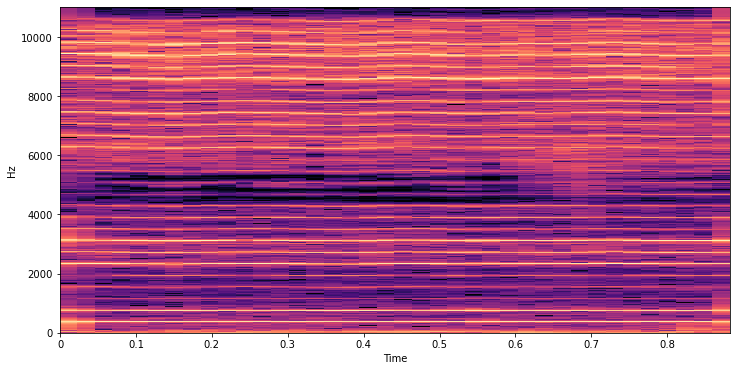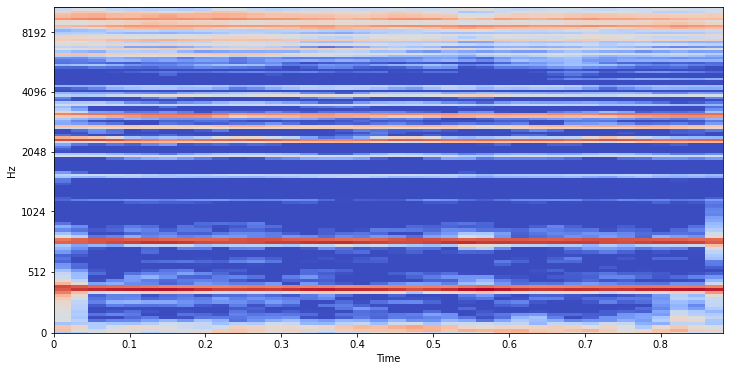